In [2]:
# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


In [32]:
# Librerías necesarias.
import pandas as pd
import glob
import numpy as np
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from matplotlib.pyplot import figure

In [17]:
files_names = []
for name in glob.glob("datos/precios/Precio_Bolsa_Nacional*"):
    files_names.append(name)


# ORDENAR LOS NOMBRES DE LOS FICHEROS
files_names.sort()
print(files_names)

['datos/precios/Precio_Bolsa_Nacional_($kwh)_1995.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1996.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1997.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1998.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_1999.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2000.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2001.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2002.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2003.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2004.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2005.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2006.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2007.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2008.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2009.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2010.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_2011.xlsx', 'datos/precios/Precio_Bolsa_Nacional_($kwh)_201

In [65]:
serie_precios_energia = pd.DataFrame(columns = ['Fecha',"Precio_Promedio"])


for name in files_names:
    excel_file = pd.read_excel(name, skiprows=3)
    total_rows = excel_file.shape[0] - 1
    for index in range (0,total_rows):
        date = excel_file.iloc[index,0]
        avg = excel_file.iloc[:,1:25].loc[index].mean()
        data = {'Fecha': [date],'Precio_Promedio': [avg]}
        df = pd.DataFrame(data)
        serie_precios_energia = pd.concat([serie_precios_energia, df], ignore_index=True)
    
# Limpieza de filas con precio promedio no definido.
serie_precios_energia.dropna(how="any", inplace=True)

#Conversion de la fecha
serie_precios_energia["Fecha"] = pd.to_datetime(serie_precios_energia["Fecha"])

#Impresion primeros 20 registros.
serie_precios_energia.head(20)

,Fecha,Precio_Promedio
0,1995-07-20,1.409435
1,1995-07-21,4.924333
2,1995-07-22,1.269500
3,1995-07-23,0.953083
4,1995-07-24,4.305917
5,1995-07-25,1.149167
6,1995-07-26,1.108625
7,1995-07-27,0.585958
8,1995-07-28,0.499792
9,1995-07-29,0.927667


In [66]:
serie_precios_energia = serie_precios_energia.sort_values(by=['Fecha'])

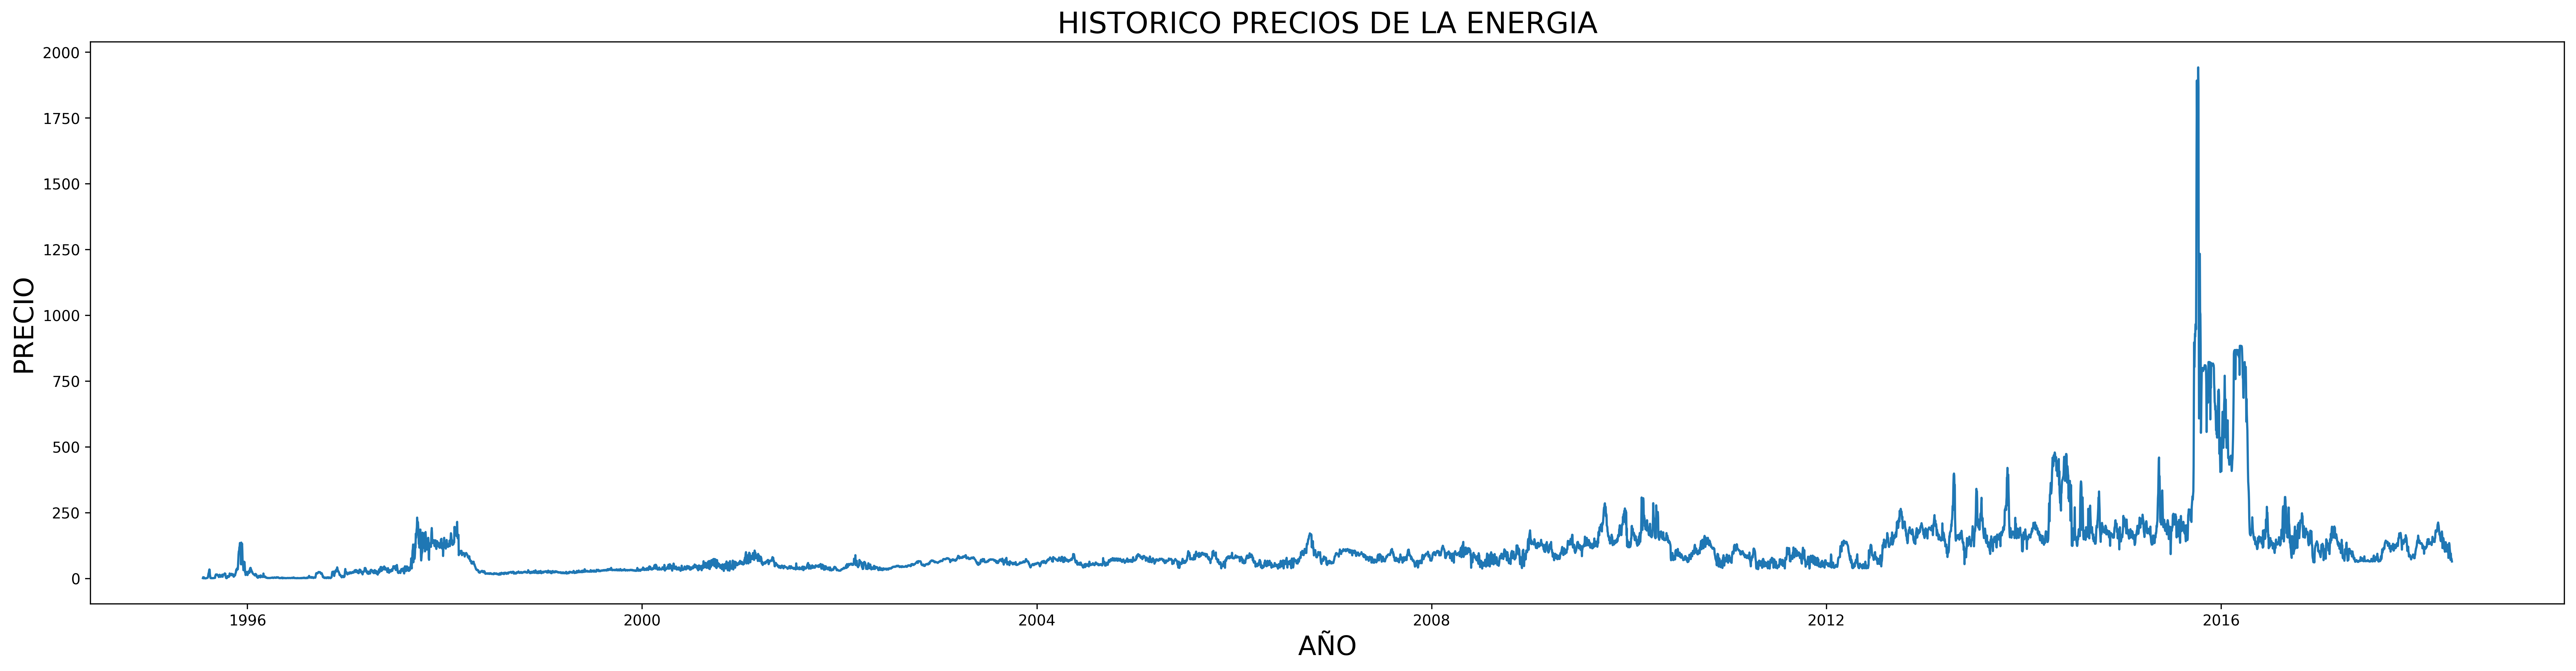

In [78]:
figure(num=None, figsize=(30,7), dpi=320, facecolor='w', edgecolor='g')
plt.plot(serie_precios_energia["Fecha"], serie_precios_energia["Precio_Promedio"])
plt.title('HISTORICO PRECIOS DE LA ENERGIA', fontsize=20)
plt.xlabel('AÑO', fontsize=18)
plt.ylabel('PRECIO ($/kWh)', fontsize=18)
plt.show()

In [75]:
# PROCESO PARA LLEVAR EL HISTORICO DE PRECIOS A LA MISMA ESCALA DADO EL IPC.

route = './datos/precios/1.2.5.IPC_Serie_variaciones.xlsx';
# Cargamos el fichero con los datos del IPC.
IPC = pd.read_excel(route, skiprows=12)

IPC = IPC.iloc[:,0:2] 
IPC = IPC.iloc[:-6] #No nos interesa las ultima 6 columnas correspondientes a los creditos
IPC.columns = ['Fecha_Formato_Mes', 'IPC']

#Convierto las fechas a formato YYYY-MM

IPC['Fecha_Formato_Mes'] = IPC['Fecha_Formato_Mes'].astype(str)
IPC['Fecha_Formato_Mes'] = IPC['Fecha_Formato_Mes'].apply(lambda x: x[:4] + '-' + x[4:])
IPC['Fecha_Formato_Mes'] = pd.to_datetime(IPC['Fecha_Formato_Mes']).dt.to_period('M')


serie_precios_energia['Fecha_Formato_Mes'] = pd.to_datetime(serie_precios_energia['Fecha'].astype(str)).dt.to_period('M')

serie_energia_normalizada = pd.merge(serie_precios_energia , IPC, on="Fecha_Formato_Mes", how="left")

print(serie_energia_normalizada.head(20))

        Fecha  Precio_Promedio Fecha_Formato_Mes    IPC
0  1995-07-20         1.409435           1995-07  20.93
1  1995-07-21         4.924333           1995-07  20.93
2  1995-07-22         1.269500           1995-07  20.93
3  1995-07-23         0.953083           1995-07  20.93
4  1995-07-24         4.305917           1995-07  20.93
5  1995-07-25         1.149167           1995-07  20.93
6  1995-07-26         1.108625           1995-07  20.93
7  1995-07-27         0.585958           1995-07  20.93
8  1995-07-28         0.499792           1995-07  20.93
9  1995-07-29         0.927667           1995-07  20.93
10 1995-07-30         0.669458           1995-07  20.93
11 1995-07-31         0.679458           1995-07  20.93
12 1995-08-01         1.106917           1995-08  21.07
13 1995-08-02         1.077500           1995-08  21.07
14 1995-08-03         1.517917           1995-08  21.07
15 1995-08-04         1.786042           1995-08  21.07
16 1995-08-05         2.383792           1995-08

In [76]:
IPC_BASE = 100 # 2018 - 12 PRESENTA IPC DE 100
serie_energia_normalizada['Precio_Normalizado'] = serie_energia_normalizada['Precio_Promedio']*(IPC_BASE/serie_energia_normalizada['IPC'])

In [77]:
print(serie_energia_normalizada.head(20))

        Fecha  Precio_Promedio Fecha_Formato_Mes    IPC  Precio_Normalizado
0  1995-07-20         1.409435           1995-07  20.93            6.734041
1  1995-07-21         4.924333           1995-07  20.93           23.527632
2  1995-07-22         1.269500           1995-07  20.93            6.065456
3  1995-07-23         0.953083           1995-07  20.93            4.553671
4  1995-07-24         4.305917           1995-07  20.93           20.572942
5  1995-07-25         1.149167           1995-07  20.93            5.490524
6  1995-07-26         1.108625           1995-07  20.93            5.296823
7  1995-07-27         0.585958           1995-07  20.93            2.799610
8  1995-07-28         0.499792           1995-07  20.93            2.387920
9  1995-07-29         0.927667           1995-07  20.93            4.432234
10 1995-07-30         0.669458           1995-07  20.93            3.198559
11 1995-07-31         0.679458           1995-07  20.93            3.246337
12 1995-08-0

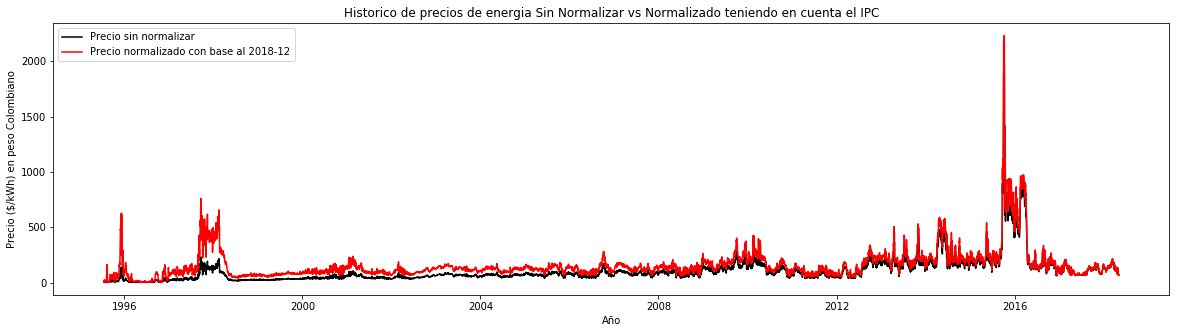

In [83]:
plt.figure(figsize=(20,5))
plt.title('Historico de precios de energia Sin Normalizar vs Normalizado teniendo en cuenta el IPC')
plt.xlabel('Año')
plt.ylabel('Precio ($/kWh) en peso Colombiano')
plt.plot(serie_energia_normalizada['Fecha'], serie_energia_normalizada['Precio_Promedio'],label="Precio sin normalizar", color='black')
plt.plot(serie_energia_normalizada['Fecha'], serie_energia_normalizada['Precio_Normalizado'],label="Precio normalizado con base al 2018-12", color='red')
plt.legend()
plt.show()